In [67]:
from typing import Tuple, NamedTuple, Any, List
import textwrap
import functools

import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import shapiro, ks_1samp, uniform, norm, expon, geom
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE

from keras.models import Sequential
from keras.layers import Dense

In [2]:
# We offer pre-filtered Google Drive files to speed up execution of this cell.

#df = pd.read_csv("user_log_format1.csv")  # SHA256: a6bc8eabc40b61a562a5e45c91e9b822418d0d863576b28a9ccd549451e55a92
#df = df[df['item_id'].isin(range(481, 640+1))]
df_user_log = pd.read_csv('https://drive.google.com/uc?id=1DwEvKOYl0hQmd2muwDa13O17smPPgn0D')
df_user_info = pd.read_csv('https://drive.google.com/uc?id=1wM9LY4rAsMLGe6GUZNQd50R8WHiH9xaf')
#df1 = pd.read_csv("user_info_format1.csv")
df2 = pd.read_csv("train_format1.csv")

# Data Visualization

In [3]:
print(np.sum(df2["label"] == 0), np.sum(df2["label"] == 1))
print(f'{np.sum(df2["label"] == 1) / len(df2) * 100:.02f}% are repeat buyers')

244912 15952
6.12% are repeat buyers


In [4]:
df_user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,7254.000000,7254.000000,7254.000000,7254.000000,7248.000000,7254.000000,7254.00000
mean,212242.874414,550.680866,856.662807,2248.200441,3430.941777,918.570720,0.32327
std,123871.986646,45.550493,454.733960,1398.951493,2393.470654,196.713235,0.82503
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.00000
25%,101420.750000,517.000000,407.000000,1234.000000,1345.000000,729.000000,0.00000
50%,216374.000000,545.000000,748.000000,1923.000000,2462.000000,1006.000000,0.00000
75%,321987.000000,591.000000,1255.000000,3659.000000,5376.000000,1109.000000,0.00000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.00000


In [5]:
df_user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id        True
time_stamp     False
action_type    False
dtype: bool

<Axes: xlabel='action_type', ylabel='count'>

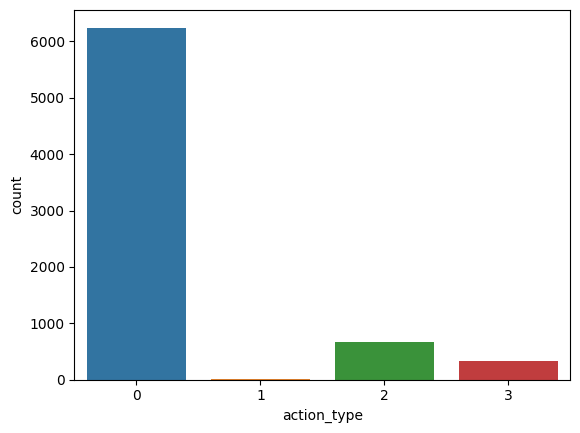

In [6]:
sns.countplot(x='action_type', data=df_user_log)

In [7]:
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


<Axes: xlabel='age_range', ylabel='count'>

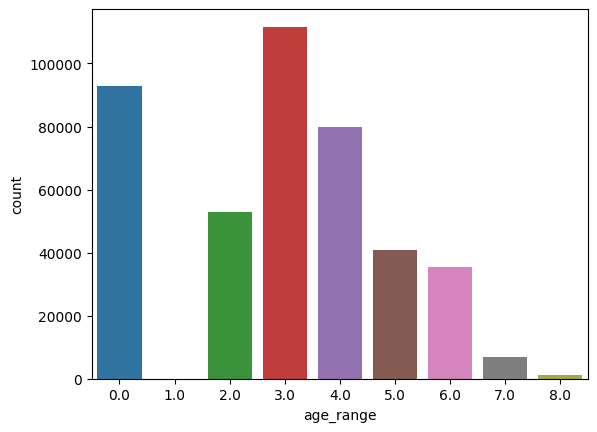

In [8]:
sns.countplot(x='age_range', data=df_user_info)

<Axes: xlabel='gender', ylabel='count'>

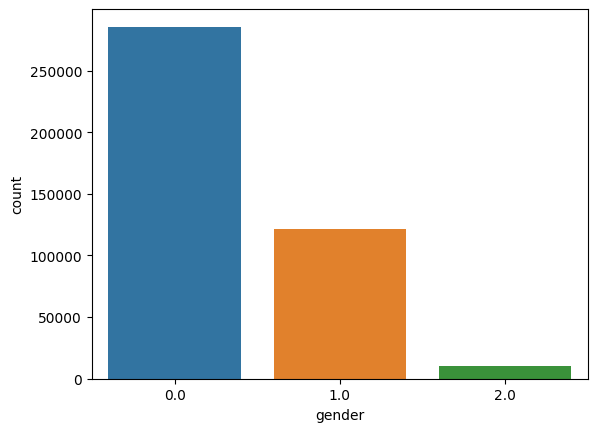

In [9]:
sns.countplot(x='gender', data=df_user_info)

# Feature Engineering
We should analyze the data more to see if we can extract more structured features.

In [10]:
merged_df = pd.merge(pd.merge(df_user_log, df_user_info, on='user_id'), df2, on='user_id')
merged_df = merged_df[merged_df.notnull().all(axis=1)]  # Remove rows with any nulls

merged_df['time_stamp'].astype('str')
merged_df['time_str'] = merged_df['time_stamp'].astype('str')
merged_df['day'] = merged_df['time_stamp'] % 100
merged_df['month'] = (merged_df['time_stamp'] - merged_df['day']) / 100
merged_df['month'] = merged_df['month'].astype('int')
merged_df['day_of_year'] = merged_df['month'].apply(lambda x: sum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][:x - 1])) + merged_df['day']  # If we have to deal with leap years, I will cry
merged_df['day_of_week'] = merged_df['day'] % 7
merged_df

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,time_str,day,month,day_of_year,day_of_week
0,69247,568,683,270,397.0,1110,0,4.0,1.0,1999,0,1110,10,11,314,3
1,69247,568,683,270,397.0,1110,0,4.0,1.0,2954,0,1110,10,11,314,3
2,327584,489,420,3845,3156.0,708,0,4.0,0.0,2397,0,708,8,7,189,1
3,91170,640,612,2246,394.0,1111,0,5.0,0.0,1742,0,1111,11,11,315,4
4,290029,495,464,4535,1720.0,1008,2,4.0,1.0,4585,0,1008,8,10,281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,280765,496,267,2115,6973.0,1101,0,0.0,0.0,4765,0,1101,1,11,305,1
5090,280765,496,267,2115,6973.0,1101,0,0.0,0.0,4765,0,1101,1,11,305,1
5091,87449,504,1213,2264,3275.0,1015,0,0.0,1.0,1816,0,1015,15,10,288,1
5092,87449,504,1213,2264,3275.0,1015,0,0.0,1.0,4518,0,1015,15,10,288,1


In [11]:
merged_df.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,day,month,day_of_year,day_of_week
count,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000
mean,212851.840837,550.306477,876.033570,2141.187599,3260.981240,921.772907,0.319313,3.273894,0.343799,2431.043444,0.080174,14.960111,9.068128,259.713863,3.200829
std,122694.289306,45.255385,467.266302,1385.563428,2342.411169,195.902156,0.824361,1.814262,0.620673,1484.175273,0.271589,8.471536,1.999778,57.537193,1.720940
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,5.000000,131.000000,0.000000
25%,112534.000000,517.000000,407.000000,966.000000,1345.000000,730.000000,0.000000,3.000000,0.000000,1200.000000,0.000000,9.000000,7.000000,211.000000,2.000000
50%,217100.000000,545.000000,748.000000,1699.000000,2431.000000,1007.000000,0.000000,3.000000,0.000000,2273.000000,0.000000,11.000000,10.000000,280.000000,4.000000
75%,321643.000000,591.000000,1255.000000,3556.000000,5097.000000,1109.000000,0.000000,4.000000,1.000000,3828.000000,0.000000,24.000000,11.000000,313.000000,4.000000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.000000,8.000000,2.000000,4993.000000,1.000000,31.000000,11.000000,315.000000,6.000000


In [12]:
def merge_multiple(*dfs, on='user_id', default=0):
    return functools.reduce(lambda x,y: pd.merge(x, y, how='outer').fillna(default, downcast='infer'), dfs)

In [13]:
# How many times has the user interacted with us, in general?
user_interaction_count = merged_df.value_counts(subset='user_id').rename("user_interaction_count").reset_index()

# How many unique times (invariant of action_type) has the user interacted with us?
# Also can be interpreted as How many unique separate days (without regrad to action_type) has the user interacted with us?
user_uniq_interaction_count = merged_df.drop(columns='action_type').drop_duplicates().value_counts(subset='user_id').rename("user_uniq_interaction_count").reset_index()
merge_multiple(user_interaction_count, user_uniq_interaction_count)

,user_id,user_interaction_count,user_uniq_interaction_count
0,135731,120,36
1,174817,40,8
2,218756,40,4
3,321987,28,1
4,183753,24,4
...,...,...,...
2097,195154,1,1
2098,195114,1,1
2099,194291,1,1
2100,194212,1,1


In [14]:
# How many times has the user interacted with us on that month?
user_month_count = merged_df.value_counts(subset=['user_id', 'month']).rename("user_month_count").reset_index()

# How many times has the user bought something from us on that month?
user_month_purchase_count = merged_df[merged_df['action_type'] == 2].value_counts(subset=['user_id', 'month']).rename("user_month_purchase_count").reset_index()

# How many times has the user interacted with us on that day?
user_day_count = merged_df.value_counts(subset=['user_id', 'day_of_year']).rename("user_day_count").reset_index()
merge_multiple(user_month_count, user_month_purchase_count, user_day_count)

,user_id,month,user_month_count,user_month_purchase_count,day_of_year,user_day_count
0,135731,9,120,12,268,72
1,135731,9,120,12,265,36
2,135731,9,120,12,269,12
3,174817,6,40,8,176,36
4,174817,6,40,8,167,4
...,...,...,...,...,...,...
2640,188649,11,1,0,310,1
2641,188321,11,1,0,315,1
2642,187072,11,1,0,309,1
2643,186856,11,1,0,313,1


In [15]:
# How many times has the user interacted with the merchant?
user_merchant_interaction_count = merged_df.value_counts(subset=['user_id', 'merchant_id']).rename("user_merchant_interaction_count").reset_index()

# How many unique times has the user interacted with the merchant?
user_uniq_merchant_interaction_count = merged_df.drop(columns='action_type').drop_duplicates().value_counts(subset=['user_id', 'merchant_id']) \
        .rename("user_uniq_merchant_interaction_count").reset_index()

# How many times has the user bought something from the merchant?
user_merchant_purchase_count = merged_df[merged_df['action_type'] == 2].value_counts(subset=['user_id', 'merchant_id']) \
        .rename("user_merchant_purchase_count").reset_index()

# How many times has the user favorited something the merchant sells?
user_merchant_favorite_count = merged_df[merged_df['action_type'] == 3].value_counts(subset=['user_id', 'merchant_id']) \
        .rename("user_merchant_favorite_count").reset_index()

merge_multiple(user_merchant_interaction_count, user_uniq_merchant_interaction_count, user_merchant_purchase_count, user_merchant_favorite_count)

,user_id,merchant_id,user_merchant_interaction_count,user_uniq_merchant_interaction_count,user_merchant_purchase_count,user_merchant_favorite_count
0,321987,1810,28,1,0,0
1,394258,200,24,5,4,0
2,376488,4607,18,6,2,0
3,132468,747,13,3,1,1
4,340967,3609,13,2,3,0
...,...,...,...,...,...,...
2913,171268,2636,1,1,0,0
2914,171556,1768,1,1,0,0
2915,171654,73,1,1,0,1
2916,171998,4818,1,1,0,0


In [16]:
# How many times has the user interacted with the item?
user_item_interaction_count = merged_df.value_counts(subset=['user_id', 'item_id']).rename("user_item_interaction_count").reset_index()

# How many unique times has the user interacted with the item?
user_uniq_item_interaction_count = merged_df.drop(columns='action_type').drop_duplicates().value_counts(subset=['user_id', 'item_id']) \
        .rename("user_uniq_item_interaction_count").reset_index()

# How many times has the user bought the item?
user_item_purchase_count = merged_df[merged_df['action_type'] == 2].value_counts(subset=['user_id', 'item_id']) \
        .rename("user_item_purchase_count").reset_index()

# How many times has the user favorited the item?
user_item_favorite_count = merged_df[merged_df['action_type'] == 3].value_counts(subset=['user_id', 'item_id']) \
        .rename("user_item_favorite_count").reset_index()

merge_multiple(user_item_interaction_count, user_uniq_item_interaction_count, user_item_purchase_count, user_item_favorite_count)

,user_id,item_id,user_item_interaction_count,user_uniq_item_interaction_count,user_item_purchase_count,user_item_favorite_count
0,135731,592,120,36,12,12
1,218756,611,40,4,4,0
2,174817,517,40,8,8,4
3,321987,628,28,1,0,0
4,394258,517,24,5,4,0
...,...,...,...,...,...,...
2129,188969,483,1,1,0,0
2130,188649,484,1,1,0,0
2131,188321,591,1,1,0,0
2132,187072,617,1,1,0,0


In [17]:
# How many times has the user interacted with the category?
user_cat_interaction_count = merged_df.value_counts(subset=['user_id', 'cat_id']).rename("user_cat_interaction_count").reset_index()

# How many unique times has the user interacted with the category?
user_uniq_cat_interaction_count = merged_df.drop(columns='action_type').drop_duplicates().value_counts(subset=['user_id', 'cat_id']) \
        .rename("user_uniq_cat_interaction_count").reset_index()
merge_multiple(user_cat_interaction_count, user_uniq_cat_interaction_count)

,user_id,cat_id,user_cat_interaction_count,user_uniq_cat_interaction_count
0,135731,1505,120,36
1,218756,177,40,4
2,174817,1255,40,8
3,321987,737,28,1
4,394258,1255,24,5
...,...,...,...,...
2129,188969,351,1,1
2130,188649,883,1,1
2131,188321,369,1,1
2132,187072,748,1,1


In [18]:
# What is the ranking of the merchant in terms of total number of items sold?
# (higher is better)
merchant_sold_rank = merged_df[merged_df['action_type'] == 2].value_counts(subset='merchant_id').rank(method='dense') \
        .rename("merchant_sold_rank").reset_index()

# What is the ranking of the merchant in terms of total number of favorites?
# (higher is better)
merchant_favorite_rank = merged_df[merged_df['action_type'] == 3].value_counts(subset='merchant_id').rank(method='dense') \
        .rename("merchant_favorite_rank").reset_index()

merge_multiple(merchant_sold_rank, merchant_favorite_rank)

,merchant_id,merchant_sold_rank,merchant_favorite_rank
0,1653,12,3
1,71,11,1
2,2954,10,0
3,3984,9,5
4,3828,8,3
...,...,...,...
318,1725,0,1
319,1755,0,1
320,1890,0,1
321,1761,0,1


In [19]:
# What is the ranking of the item in terms of total sold?
# (higher is better)
item_sold_rank = merged_df[merged_df['action_type'] == 2].value_counts(subset='item_id').rank(method='dense') \
        .rename("item_sold_rank").reset_index()

# What is the ranking of the item in terms of total favorited?
# (higher is better)
item_favorite_rank = merged_df[merged_df['action_type'] == 3].value_counts(subset='item_id').rank(method='dense') \
        .rename("item_favorite_rank").reset_index()

merge_multiple(item_sold_rank, item_favorite_rank)

,item_id,item_sold_rank,item_favorite_rank
0,517,16,13
1,548,15,2
2,493,14,12
3,568,13,10
4,591,12,5
...,...,...,...
69,532,0,1
70,519,0,1
71,510,0,1
72,491,0,1


In [20]:
merged_df = merge_multiple(merged_df, user_interaction_count, user_uniq_interaction_count, user_month_count, user_month_purchase_count, \
                           user_day_count, user_merchant_interaction_count, user_uniq_merchant_interaction_count, user_merchant_purchase_count, \
                           user_merchant_favorite_count, user_item_interaction_count, user_uniq_item_interaction_count, user_item_purchase_count, \
                           user_item_favorite_count, user_cat_interaction_count, user_uniq_cat_interaction_count, merchant_sold_rank, \
                           merchant_favorite_rank, item_sold_rank, item_favorite_rank)
display(merged_df.columns)
merged_df = merged_df.drop(columns=['time_stamp', 'time_str']) # Let's drop these two time columns as they are better represented as day_of_year
merged_df

Index(['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'time_stamp',
       'action_type', 'age_range', 'gender', 'merchant_id', 'label',
       'time_str', 'day', 'month', 'day_of_year', 'day_of_week',
       'user_interaction_count', 'user_uniq_interaction_count',
       'user_month_count', 'user_month_purchase_count', 'user_day_count',
       'user_merchant_interaction_count',
       'user_uniq_merchant_interaction_count', 'user_merchant_purchase_count',
       'user_merchant_favorite_count', 'user_item_interaction_count',
       'user_uniq_item_interaction_count', 'user_item_purchase_count',
       'user_item_favorite_count', 'user_cat_interaction_count',
       'user_uniq_cat_interaction_count', 'merchant_sold_rank',
       'merchant_favorite_rank', 'item_sold_rank', 'item_favorite_rank'],
      dtype='object')

,user_id,item_id,cat_id,seller_id,brand_id,action_type,age_range,gender,merchant_id,label,...,user_item_interaction_count,user_uniq_item_interaction_count,user_item_purchase_count,user_item_favorite_count,user_cat_interaction_count,user_uniq_cat_interaction_count,merchant_sold_rank,merchant_favorite_rank,item_sold_rank,item_favorite_rank
0,69247,568,683,270,397,0,4,1,1999,0,...,2,2,0,0,2,2,0,0,13,10
1,69247,568,683,270,397,0,4,1,2954,0,...,2,2,0,0,2,2,10,0,13,10
2,183132,568,683,270,397,0,3,0,2954,1,...,3,3,0,0,3,3,10,0,13,10
3,7423,568,683,270,397,2,0,0,2954,0,...,4,2,4,0,4,2,10,0,13,10
4,7423,568,683,270,397,2,0,0,2954,0,...,4,2,4,0,4,2,10,0,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5059,186726,554,1280,3229,6972,0,2,1,2036,0,...,4,1,0,0,4,1,1,0,0,0
5060,186726,554,1280,3229,6972,0,2,1,2036,0,...,4,1,0,0,4,1,1,0,0,0
5061,186726,554,1280,3229,6972,0,2,1,2036,0,...,4,1,0,0,4,1,1,0,0,0
5062,186726,554,1280,3229,6972,0,2,1,2036,0,...,4,1,0,0,4,1,1,0,0,0


## Data Visualization on New Features



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='month', ylabel='Density'>

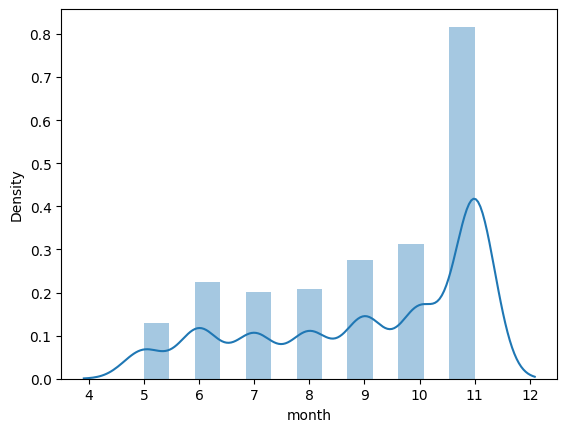

In [21]:
sns.distplot(merged_df['month'], hist=True)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='day_of_year', ylabel='Density'>

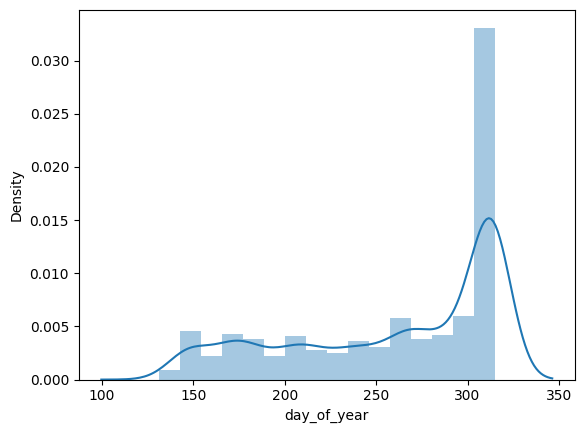

In [22]:
sns.distplot(merged_df['day_of_year'], hist=True)

<Axes: xlabel='gender', ylabel='count'>

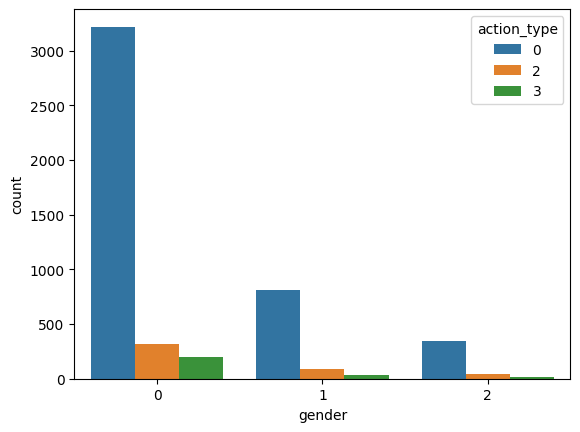

In [23]:
sns.countplot(x='gender', hue='action_type', data=merged_df)

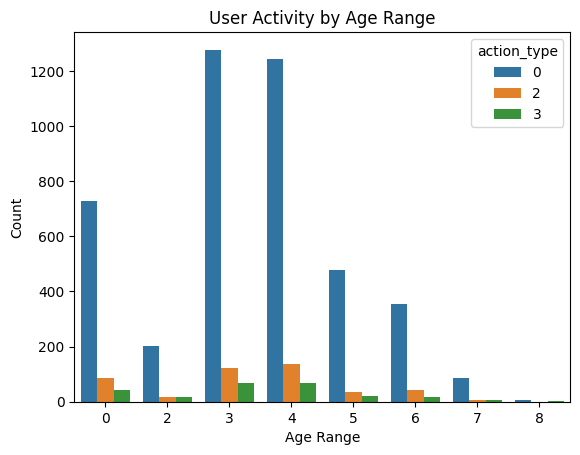

In [24]:
# create a countplot of user activity by age range
sns.countplot(x='age_range', hue='action_type', data=merged_df)
plt.title('User Activity by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.show()

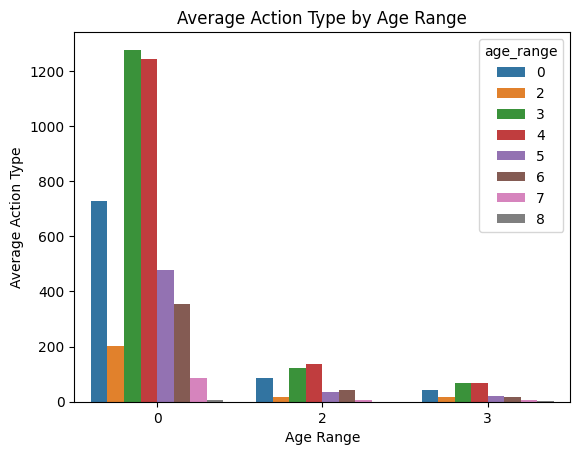

In [25]:
# create a barplot of average action type by age range
sns.countplot(x='action_type', hue='age_range', data=merged_df)
plt.title('Average Action Type by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Average Action Type')
plt.show()

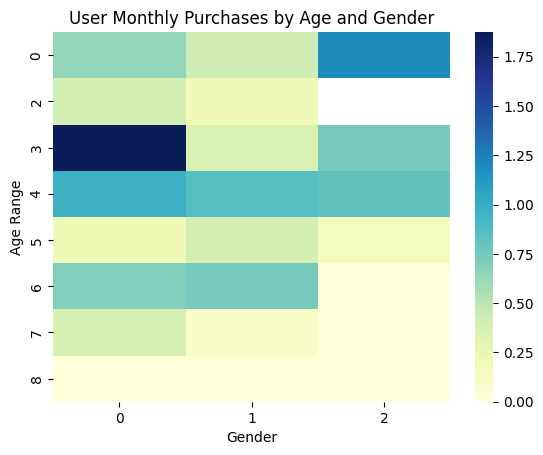

In [26]:
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='user_month_purchase_count', aggfunc='mean')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Monthly Purchases by Age and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()

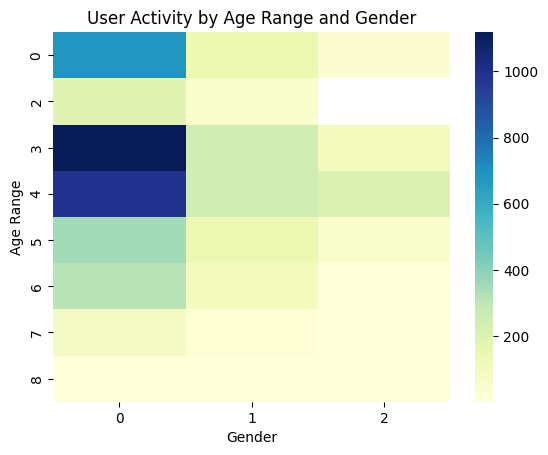

In [27]:
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='action_type', aggfunc='count')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Activity by Age Range and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()

# Feature Ranking
Pretty sure statistical summary is taken care by the above task.

In [28]:
any_norm = merged_df.apply(lambda x: shapiro(x.head(1000)).pvalue)
any(merged_df.apply(lambda x: shapiro(x.head(1000)).pvalue) > 0.05)
# Nothing is normally distributed!

False

In [57]:
# Don't lean into these types too much. Some of them are different, but functionally the same
class EvaluationResults(NamedTuple):
    acc: float
    prec: float
    recall: float
    f1: float
    confusion: np.ndarray
    roc: Tuple[np.ndarray, np.ndarray, np.ndarray]
    roc_auc: float
    model: Any
    columns: List[str]
    data: pd.DataFrame
    
def reduce_data(data, onehot=[], drop=[]):
    #print(data.shape)
    data_reduced = data.drop(columns=drop)
    #print(data_reduced.shape)
    data_reduced = pd.get_dummies(data_reduced, columns=onehot)
    #print(data_reduced.shape)
    
    X = data_reduced.drop(columns=['label'])
    y = data_reduced['label']
    return X, y

def evaluate(model, data, onehot=[], drop=[], name=None, stratify=True, pred_func=None, proba_func=None):
    X, y = reduce_data(data, onehot, drop)
    
    # Random state is column-invariant
    # We stratify because only 6% of all recorded actions do result in a sale!
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #print(np.sum(y_train == 1) / len(y_train))
    
    model.fit(X_train, y_train)
    if pred_func is None:
        y_pred = model.predict(X_test)
    else:
        y_pred = pred_func(model, X_test)
        
    if proba_func is None:
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = proba_func(model, X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    roc = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    if name:
        setattr(model, "__name", name)
    else:
        setattr(model, "__name", model.__class__.__name__)
        
    return EvaluationResults(acc, prec, recall, f1, confusion, roc, roc_auc, model, X.columns, X)

def display_evaluation(*evals, show_plots=True, show_table=True):
    table_data = [(x.acc, x.prec, x.recall, x.f1, x.roc_auc) for x in evals]
    conf_data = [x.confusion for x in evals]
    roc_data = [(x.roc, x.roc_auc) for x in evals]
    model_data = [x.model for x in evals]
    
    table = pd.DataFrame(table_data, columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC Score"])
    table = table.rename(mapper={i: x.__name for i, x in enumerate(model_data)})   
    
    if show_table:
        if len(table_data) == 1:
            display(table.T.style.format('{:.2%}'))
        else:
            display(table.style.format('{:.2%}').highlight_max(props='font-weight: bold', axis=0))
            #display(table)
    
    if show_plots:
        fig, ax = plt.subplots()
        for (roc, roc_auc), model in zip(roc_data, model_data):
            fpr, tpr, thresholds = roc
            roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.__name)
            roc_plot.plot(ax=ax)
            ax.set_title('ROC Curve(s)')
        plt.show()
        
        fig, axs = plt.subplots(nrows=((len(model_data) + 1) // 2), ncols=2, figsize=(8,4*((len(model_data) + 1) // 2)))
        axs = axs.flatten()
        for i, (confusion, model) in enumerate(zip(conf_data, model_data)):
            conf_plot = ConfusionMatrixDisplay(confusion_matrix=confusion)
            conf_plot.plot(ax=axs[i])
            axs[i].set_title(textwrap.fill('Confusion Matrix of ' + model.__name, width=30), fontsize=10)
        fig.tight_layout()
        if len(model_data) % 2 == 1:
            axs[-1].axis('off')
        plt.show()
        
def display_importance(evals, onehot=[], limit=20):
    importance = None
    if hasattr(evals.model, "coef_"):
        importance = np.abs(evals.model.coef_[0])
    elif hasattr(evals.model, "feature_importances_"):
        importance = evals.model.feature_importances_
    else:
        raise Exception("Cannot extract importances")
        
    s = pd.Series(importance, index=evals.columns).sort_values().tail(20)
    for col in onehot:
        cols = [_ for _ in s.index if _.startswith(col)]
        col_sum = s[cols].sum()
        s = s.drop(cols)
        s[col] = col_sum
        
    if limit == 0:
        return s.sort_values()
    else:
        return s.sort_values().tail(limit)

<Axes: >

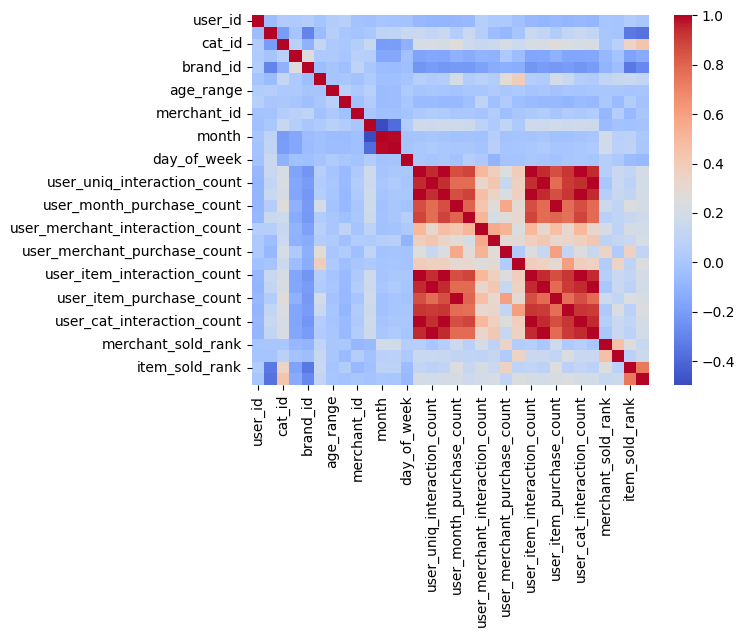

In [58]:
# Here's some correlations
# We only do correlations on reduced, as doing so on one-hot is computationally expensive to visualize (due to the many columns)
sns.heatmap(reduce_data(merged_df)[0].corr(), cmap='coolwarm')

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,96.35%,97.83%,55.56%,70.87%,87.36%
Random Forest (unstratified),95.46%,88.00%,52.38%,65.67%,86.49%


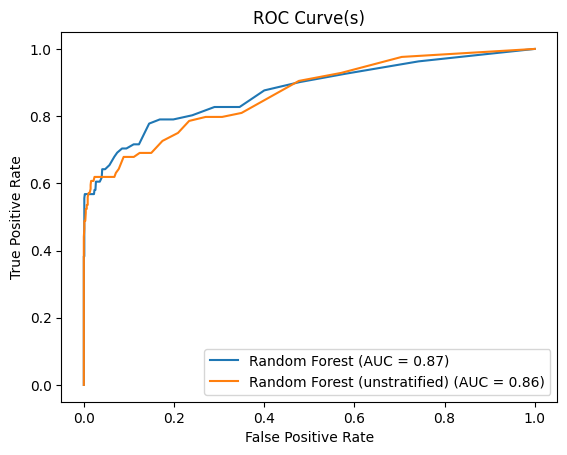

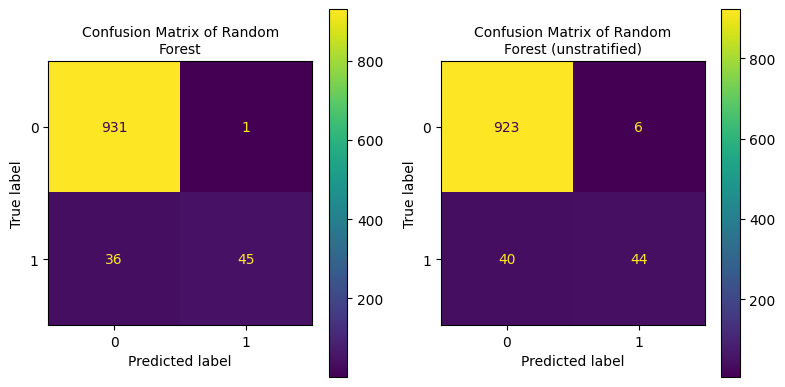

item_sold_rank                     0.021737
gender                             0.021926
user_item_interaction_count        0.022107
user_cat_interaction_count         0.022133
item_favorite_rank                 0.022642
user_merchant_interaction_count    0.023150
user_month_count                   0.023287
user_interaction_count             0.024366
day_of_week                        0.027468
brand_id                           0.033350
seller_id                          0.036852
item_id                            0.037183
cat_id                             0.040444
day                                0.042170
age_range                          0.044515
day_of_year                        0.048060
merchant_favorite_rank             0.051892
merchant_sold_rank                 0.069449
user_id                            0.082942
merchant_id                        0.140868
dtype: float64

In [59]:
# Before we touch the data, let's gain a benchmark on stratified vs unstratified on the label.
rfor = evaluate(RandomForestClassifier(random_state=0), merged_df, name="Random Forest")
rfor_unstratified = evaluate(RandomForestClassifier(random_state=0), merged_df, name="Random Forest (unstratified)", stratify=False)
display_evaluation(rfor, rfor_unstratified,)
display_importance(rfor)

In [32]:
onehots = ['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'merchant_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
rfor_onehot = evaluate(RandomForestClassifier(random_state=0), merged_df, onehot=onehots, name="Random Forest (onehot)")
display_evaluation(rfor, rfor_onehot, show_plots=False)
display_importance(rfor_onehot, onehot=onehots, limit=0)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,96.35%,97.83%,55.56%,70.87%,87.36%
Random Forest (onehot),96.25%,95.74%,55.56%,70.31%,89.22%


day_of_week                         0.000000
month                               0.000000
day                                 0.000000
action_type                         0.000000
brand_id                            0.000000
seller_id                           0.000000
cat_id                              0.000000
item_id                             0.000000
day_of_year                         0.000000
age_range                           0.006914
user_uniq_cat_interaction_count     0.007779
user_uniq_interaction_count         0.008638
gender                              0.008657
user_uniq_item_interaction_count    0.008741
user_merchant_interaction_count     0.009490
user_item_interaction_count         0.010831
user_day_count                      0.010974
user_cat_interaction_count          0.011785
user_month_count                    0.011862
user_interaction_count              0.011898
merchant_favorite_rank              0.031169
merchant_id                         0.031811
user_id   

In [33]:
to_drop = ["day_of_week", "month", "day", "action_type", "brand_id", "seller_id", "cat_id", "item_id", "day_of_year"]
onehots = ["merchant_id", "user_id", "age_range"]
rfor_drop = evaluate(RandomForestClassifier(random_state=0), merged_df, drop=to_drop, onehot=onehots, name="Random Forest (onehot, drop)")
display_evaluation(rfor, rfor_onehot, rfor_drop, show_plots=False)
display_importance(rfor_drop, onehot=onehots, limit=0)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,96.35%,97.83%,55.56%,70.87%,87.36%
Random Forest (onehot),96.25%,95.74%,55.56%,70.31%,89.22%
"Random Forest (onehot, drop)",96.84%,100.00%,60.49%,75.38%,90.92%


age_range                           0.000000
user_uniq_cat_interaction_count     0.008674
user_uniq_interaction_count         0.010215
gender                              0.010412
user_uniq_item_interaction_count    0.011122
user_cat_interaction_count          0.012633
user_day_count                      0.012712
user_month_count                    0.012714
user_interaction_count              0.012777
user_merchant_interaction_count     0.013161
user_item_interaction_count         0.013187
item_favorite_rank                  0.019330
item_sold_rank                      0.019362
merchant_favorite_rank              0.028886
user_id                             0.028890
merchant_id                         0.033872
merchant_sold_rank                  0.035671
dtype: float64

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,96.35%,97.83%,55.56%,70.87%,87.36%
Random Forest (onehot),96.25%,95.74%,55.56%,70.31%,89.22%
"Random Forest (onehot, drop)",96.84%,100.00%,60.49%,75.38%,90.92%
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%


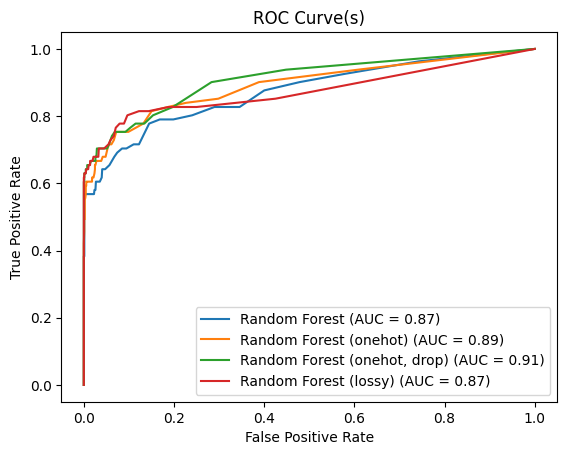

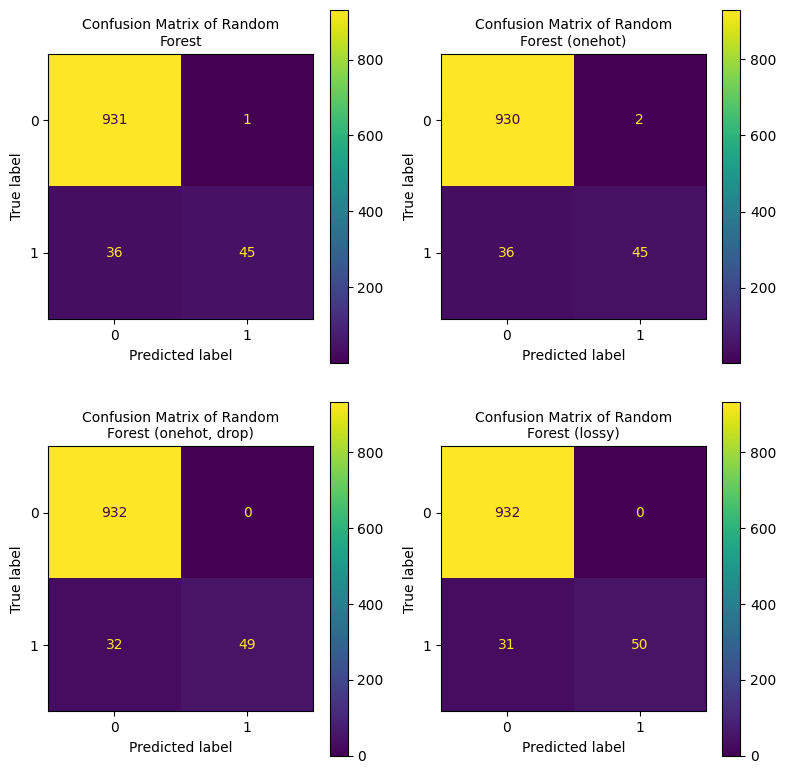

gender                              0.011364
user_uniq_item_interaction_count    0.011387
user_uniq_interaction_count         0.012032
user_merchant_interaction_count     0.012647
user_day_count                      0.013491
user_month_count                    0.013622
user_item_interaction_count         0.014707
user_interaction_count              0.014877
user_cat_interaction_count          0.015260
item_sold_rank                      0.019615
item_favorite_rank                  0.020784
merchant_favorite_rank              0.027431
merchant_sold_rank                  0.030982
merchant_id                         0.035478
user_id                             0.039558
dtype: float64

In [34]:
to_drop = ["day_of_week", "month", "day", "action_type", "brand_id", "seller_id", "cat_id", "item_id", "day_of_year", "age_range", \
           "user_uniq_cat_interaction_count"]
onehots = ["merchant_id", "user_id"]
rfor_lossy = evaluate(RandomForestClassifier(random_state=0), merged_df, drop=to_drop, onehot=onehots, name="Random Forest (lossy)")
display_evaluation(rfor, rfor_onehot, rfor_drop, rfor_lossy)
display_importance(rfor_lossy, onehot=onehots)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
"Random Forest (onehot, drop)",96.84%,100.00%,60.49%,75.38%,90.92%
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
Random Forest (only drop),96.25%,93.88%,56.79%,70.77%,89.15%


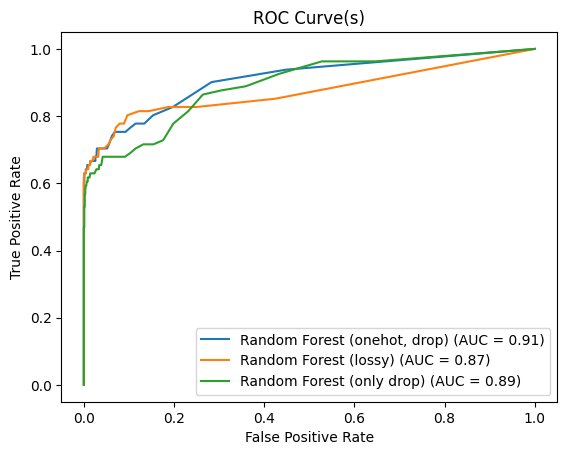

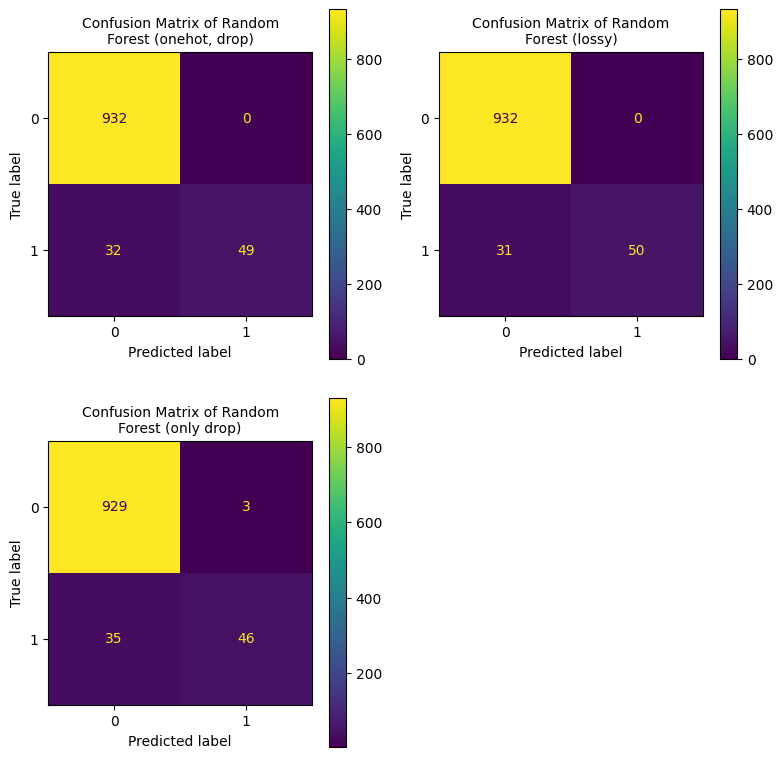

user_item_favorite_count                0.012305
user_month_purchase_count               0.014958
user_item_purchase_count                0.014983
user_uniq_merchant_interaction_count    0.016201
user_merchant_purchase_count            0.017707
user_uniq_item_interaction_count        0.019904
user_uniq_interaction_count             0.020592
user_day_count                          0.022507
user_cat_interaction_count              0.024383
user_item_interaction_count             0.026258
user_interaction_count                  0.027891
user_month_count                        0.028521
user_merchant_interaction_count         0.030682
gender                                  0.032208
item_sold_rank                          0.066173
merchant_favorite_rank                  0.066243
item_favorite_rank                      0.069133
merchant_sold_rank                      0.082251
user_id                                 0.188452
merchant_id                             0.208718
dtype: float64

In [35]:
to_drop = ["day_of_week", "month", "day", "action_type", "brand_id", "seller_id", "cat_id", "item_id", "day_of_year", "age_range", \
           "user_uniq_cat_interaction_count"]
rfor_onlydrop = evaluate(RandomForestClassifier(random_state=0), merged_df, drop=to_drop, name="Random Forest (only drop)")
display_evaluation(rfor_drop, rfor_lossy, rfor_onlydrop)
display_importance(rfor_onlydrop)

<class 'shap.explainers._tree.Tree'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


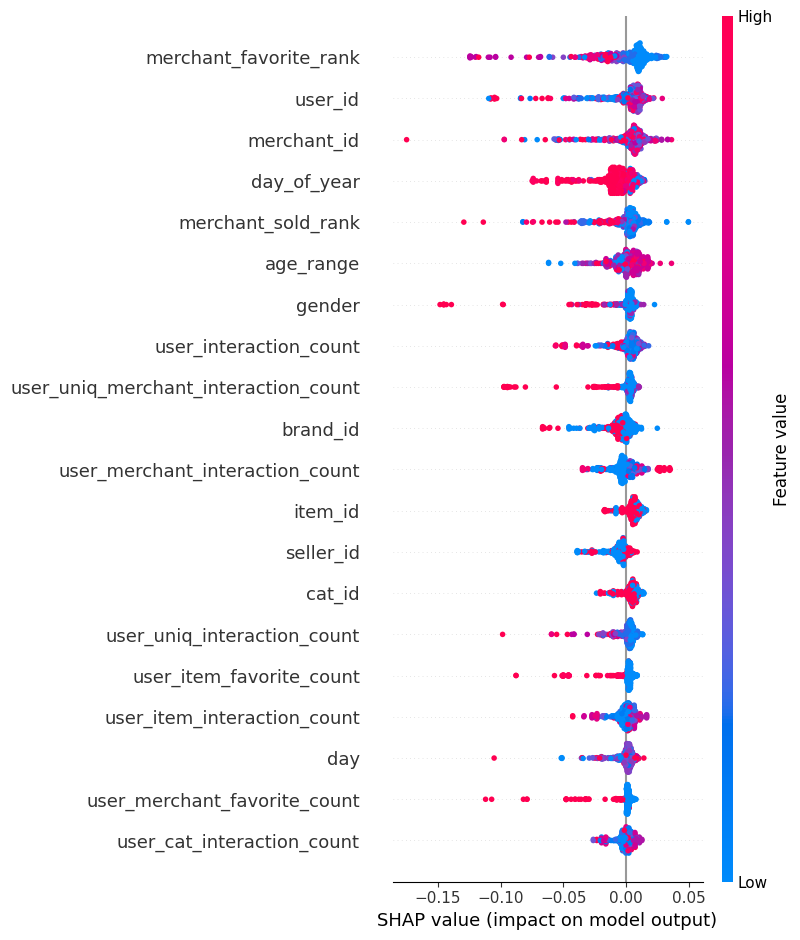

In [36]:
# Let's run Shapley analysis on forest (as that is why we ran it in the first place).
explainer = shap.TreeExplainer(rfor.model)
shap_values = explainer.shap_values(rfor.data.head(500))
print(type(explainer))
shap.summary_plot(shap_values[0], rfor.data.head(500))

In [37]:
# We do not run it on one-hot encoded data, because of the sheer amount of columns it produces.
#
# Note that merchant_id, user_id, cat_id, item_id, seller_id, brand_id are all non-categorical data with values that don't really correspond with one another.
# Meaning that it makes sense that the colors of the dots are mixed. However, we can still see it influence our output.
#
# The ranking of the merchant in terms of total number of favorites turns out to be the best feature for prediction
# Interestingly, a lower value has a positive impact on model output, meaning that the fewer favorites a merchant has, the more likely it is for a customer to be a repeat buyer.
# We see this pattern repeat for merchant_sold_rank (how many things a merchant has sold), user_uniq_merchant_interaction_count
# (how many unique interactions are there between a specific user and merchant), user_uniq_interaction_count (how many unique times a user interacted with us),
# user_item_favorite_count (how many times a user favorited an item), and user_merchant_favorite_count (how many times a user favorited something from a specific merchant).
#
# If we look at day of year, we can see that many sales later in the year influence the value negatively stronger than any other day in the year
# We see that the age range is almost separated, meaning younger people are more likely to be repeat buyers
#
# We also see a giant blob of blue just to the right of 0, meaning that females are more likely to be repeat buyers. Interestingly, males and unknowns
# are more likely to be spread out further, meaning that the any other gender besides female will have a greater absolute impact on output.
#
# user_merchant_interaction_count (or the number of times a user interacted with a merchant), is flayed, but has a solid blob of blue to the left of 0, meaning
# that people who have only a couple of interactions will be less likely to be repeat buyers
#
# user_item_interaction_count (or the number of times a user interacted with the same item) has blue in the middle and red ends, meaning that interacting it
# fewer times is less likely to change the output, but interacting more with the item makes it more likely for you to either be a repeat buyer or not
#
# user_cat_interaction_count (or the number of times a user interacted with a particular category) is the least important feature according to Shapley analysis,
# showing a much milder story similar to that of user_item_interaction_count

In [38]:
# Now let's do some PCA!
# Note that we really don't expect this to perform well as it is not normally distributed.

pca1 = PCA(n_components=1).fit(reduce_data(merged_df)[0])
print(sum(pca1.explained_variance_ratio_))
pca5 = PCA(n_components=3).fit(reduce_data(merged_df)[0])
print(sum(pca5.explained_variance_ratio_))

pcas=[]
for i in range(1,18 + 1):
    pl = Pipeline([
        ('pca', PCA(n_components=i)),
        ('clf', RandomForestClassifier(random_state=0))
    ])
    pcas.append(evaluate(pl, merged_df, name=f"PCA n={i} RFor Pipeline"))
display_evaluation(rfor_lossy, *pcas, show_plots=False)

0.999347935369523
0.9998708214517436


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=1 RFor Pipeline,94.27%,63.86%,65.43%,64.63%,83.18%
PCA n=2 RFor Pipeline,96.05%,88.68%,58.02%,70.15%,83.87%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
PCA n=4 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.38%
PCA n=5 RFor Pipeline,95.95%,87.04%,58.02%,69.63%,86.50%
PCA n=6 RFor Pipeline,95.95%,88.46%,56.79%,69.17%,85.55%
PCA n=7 RFor Pipeline,95.76%,88.00%,54.32%,67.18%,84.96%
PCA n=8 RFor Pipeline,95.95%,93.48%,53.09%,67.72%,84.89%
PCA n=9 RFor Pipeline,96.15%,95.65%,54.32%,69.29%,82.93%


In [39]:
# What if we dropped and one-hot the same columns as we did for Random Forest, lossy?
to_drop = ["day_of_week", "month", "day", "action_type", "brand_id", "seller_id", "cat_id", "item_id", "day_of_year", "age_range", \
           "user_uniq_cat_interaction_count"]
onehots = ["merchant_id", "user_id"]

pcas_lossy=[]
for i in range(1,18 + 1):
    pl = Pipeline([
        ('pca', PCA(n_components=i)),
        ('clf', RandomForestClassifier(random_state=0))
    ])
    pcas_lossy.append(evaluate(pl, merged_df, drop=to_drop, onehot=onehots, name=f"PCA n={i} (lossy) RFor Pipeline"))
display_evaluation(rfor_lossy, *pcas_lossy, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=1 (lossy) RFor Pipeline,94.18%,65.28%,58.02%,61.44%,80.05%
PCA n=2 (lossy) RFor Pipeline,95.56%,83.33%,55.56%,66.67%,81.76%
PCA n=3 (lossy) RFor Pipeline,95.26%,78.95%,55.56%,65.22%,84.79%
PCA n=4 (lossy) RFor Pipeline,95.46%,81.82%,55.56%,66.18%,83.01%
PCA n=5 (lossy) RFor Pipeline,95.46%,81.82%,55.56%,66.18%,84.35%
PCA n=6 (lossy) RFor Pipeline,95.56%,83.33%,55.56%,66.67%,83.87%
PCA n=7 (lossy) RFor Pipeline,95.56%,83.33%,55.56%,66.67%,83.97%
PCA n=8 (lossy) RFor Pipeline,95.66%,84.91%,55.56%,67.16%,84.36%
PCA n=9 (lossy) RFor Pipeline,95.56%,83.33%,55.56%,66.67%,86.85%


In [40]:
# Let's perform LDA
# Like PCA, we expect to do poorly because it is not normally distributed.
lda = evaluate(LinearDiscriminantAnalysis(store_covariance=True), merged_df, name="LDA")
display_evaluation(rfor_lossy, pcas[2], lda, show_plots=False)
display_importance(lda)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA,92.00%,50.00%,2.47%,4.71%,62.83%


user_day_count                           0.032031
merchant_sold_rank                       0.039095
day_of_week                              0.039826
user_item_favorite_count                 0.049065
user_item_purchase_count                 0.052367
user_month_count                         0.104015
user_merchant_interaction_count          0.132992
merchant_favorite_rank                   0.152952
user_merchant_favorite_count             0.251376
gender                                   0.305733
day                                      0.421440
day_of_year                              0.422267
user_uniq_merchant_interaction_count     0.446369
user_uniq_item_interaction_count         0.672734
user_uniq_cat_interaction_count          0.672734
user_item_interaction_count              0.674387
user_cat_interaction_count               0.674387
user_uniq_interaction_count              1.432364
user_interaction_count                   1.457652
month                                   13.039129


In [41]:
# But if we add in onehots, we get a different answer
onehots = ['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'merchant_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
lda_onehot = evaluate(LinearDiscriminantAnalysis(), merged_df, onehot=onehots, name="LDA (onehot)")
display_evaluation(rfor_lossy, pcas[2], lda, lda_onehot, show_plots=False)
display_importance(lda_onehot, onehot=onehots)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA,92.00%,50.00%,2.47%,4.71%,62.83%
LDA (onehot),93.48%,57.58%,70.37%,63.33%,87.32%


item_id           0.000000
cat_id            0.000000
seller_id         0.000000
brand_id          0.000000
action_type       0.000000
age_range         0.000000
day               0.000000
month             0.000000
day_of_year       0.000000
day_of_week       0.000000
merchant_id    2809.645416
user_id        6546.085739
dtype: float64

In [42]:
# What if we just dropped everything but user_id and merchant_id?
onehots = ['user_id', 'merchant_id']
lda_reduced = evaluate(LinearDiscriminantAnalysis(), merged_df[['user_id', 'merchant_id', 'label']], onehot=onehots, name="LDA (severely reduced)")
display_evaluation(rfor_lossy, pcas[2], lda, lda_onehot, lda_reduced, show_plots=False)
display_importance(lda_reduced, onehot=onehots)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA,92.00%,50.00%,2.47%,4.71%,62.83%
LDA (onehot),93.48%,57.58%,70.37%,63.33%,87.32%
LDA (severely reduced),93.68%,58.76%,70.37%,64.04%,87.12%


merchant_id    2414.462371
user_id        7281.474050
dtype: float64

In [43]:
# What if we dropped merchant_id and user_id?
onehots = ['item_id', 'cat_id', 'seller_id', 'brand_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
lda_lossy = evaluate(LinearDiscriminantAnalysis(), merged_df, onehot=onehots, drop=["user_id", "merchant_id"], name="LDA (lossy)")
display_evaluation(rfor_lossy, pcas[2], lda, lda_onehot, lda_lossy, show_plots=False)
display_importance(lda_lossy, onehot=onehots)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA,92.00%,50.00%,2.47%,4.71%,62.83%
LDA (onehot),93.48%,57.58%,70.37%,63.33%,87.32%
LDA (lossy),90.33%,22.58%,8.64%,12.50%,64.44%


action_type     0.000000
age_range       0.000000
month           0.000000
day_of_year     0.000000
day_of_week     0.000000
cat_id          8.954292
seller_id      12.799499
item_id        17.953666
brand_id       17.953666
day            34.850915
dtype: float64

<Axes: >

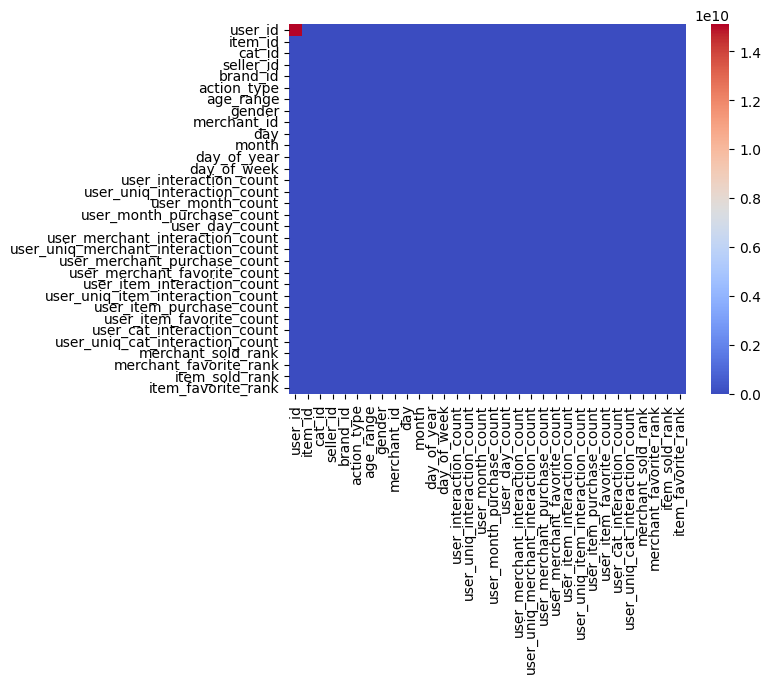

In [44]:
sns.heatmap(lda.model.covariance_, cmap='coolwarm', xticklabels=lda.columns, yticklabels=lda.columns)

<Axes: >

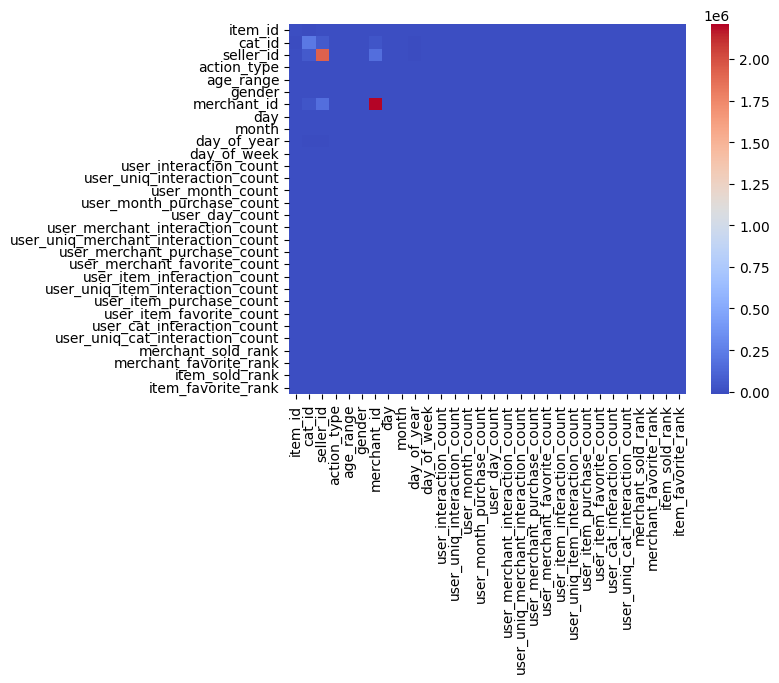

In [45]:
lda_reduced = evaluate(LinearDiscriminantAnalysis(store_covariance=True), merged_df, drop=["user_id", "brand_id"], name="LDA (reduced)")
sns.heatmap(lda_reduced.model.covariance_, cmap='coolwarm', xticklabels=lda_reduced.columns, yticklabels=lda_reduced.columns)

In [46]:
# Let's use RFE for feature analysis. Let's go back to Random Forest

rfe_rfors = []
for i in range(1, 18+1):
    rfe_rfors.append(evaluate(RFE(RandomForestClassifier(random_state=0), n_features_to_select=i), merged_df, name=f"Random Forest (RFE {i})"))
display_evaluation(rfor_lossy, pcas[2], *rfe_rfors, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
Random Forest (RFE 1),91.31%,45.07%,39.51%,42.11%,80.29%
Random Forest (RFE 2),96.84%,98.04%,61.73%,75.76%,87.61%
Random Forest (RFE 3),96.15%,90.38%,58.02%,70.68%,89.14%
Random Forest (RFE 4),95.85%,88.24%,55.56%,68.18%,87.08%
Random Forest (RFE 5),96.05%,91.84%,55.56%,69.23%,87.02%
Random Forest (RFE 6),96.35%,95.83%,56.79%,71.32%,89.90%
Random Forest (RFE 7),96.35%,95.83%,56.79%,71.32%,86.76%
Random Forest (RFE 8),95.95%,91.67%,54.32%,68.22%,86.78%


In [47]:
# We avoid using RFE for the pipeline because PCA already does its job at getting the most important features
# Adding another layer would only cause the model/pipeline to get lossy

# Prediction Model
In addition to the Random Forest, PCA, and LDA above, we include a naive Bayes classifier and non-parametric techniques.

In [48]:
# We really don't expect a naive Bayes classifier to do well, as it depends on normal distribution.
bayes = evaluate(GaussianNB(), merged_df, name="Bayes")
display_evaluation(rfor_lossy, pcas[2], lda_lossy, bayes, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA (lossy),90.33%,22.58%,8.64%,12.50%,64.44%
Bayes,89.63%,7.14%,2.47%,3.67%,60.41%


In [49]:
onehots = ['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'merchant_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
bayes_onehot = evaluate(GaussianNB(), merged_df, onehot=onehots, name="Bayes (onehot)")
display_evaluation(rfor_lossy, pcas[2], lda_lossy, bayes, bayes_onehot, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA (lossy),90.33%,22.58%,8.64%,12.50%,64.44%
Bayes,89.63%,7.14%,2.47%,3.67%,60.41%
Bayes (onehot),85.98%,32.77%,71.60%,44.96%,79.42%


In [50]:
onehots = ['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'merchant_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
bayes_bern = evaluate(BernoulliNB(), merged_df, onehot=onehots, name="Bayes (Bernoulli)")
display_evaluation(rfor_lossy, pcas[2], lda_lossy, bayes_onehot, bayes_bern, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),96.94%,100.00%,61.73%,76.34%,87.43%
PCA n=3 RFor Pipeline,96.15%,90.38%,58.02%,70.68%,87.69%
LDA (lossy),90.33%,22.58%,8.64%,12.50%,64.44%
Bayes (onehot),85.98%,32.77%,71.60%,44.96%,79.42%
Bayes (Bernoulli),91.91%,40.00%,2.47%,4.65%,75.36%


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
kNN (k=1),94.08%,62.35%,65.43%,63.86%,81.00%
kNN (k=2),94.47%,76.60%,44.44%,56.25%,80.15%
kNN (k=3),92.99%,58.06%,44.44%,50.35%,82.14%
kNN (k=4),93.48%,67.44%,35.80%,46.77%,80.99%
kNN (k=5),92.79%,58.00%,35.80%,44.27%,80.33%
kNN (k=6),92.69%,59.46%,27.16%,37.29%,79.20%
kNN (k=7),92.50%,56.10%,28.40%,37.70%,79.20%
kNN (k=8),92.40%,58.33%,17.28%,26.67%,79.22%
kNN (k=9),91.71%,45.16%,17.28%,25.00%,78.28%
kNN (k=10),91.61%,42.86%,14.81%,22.02%,77.74%


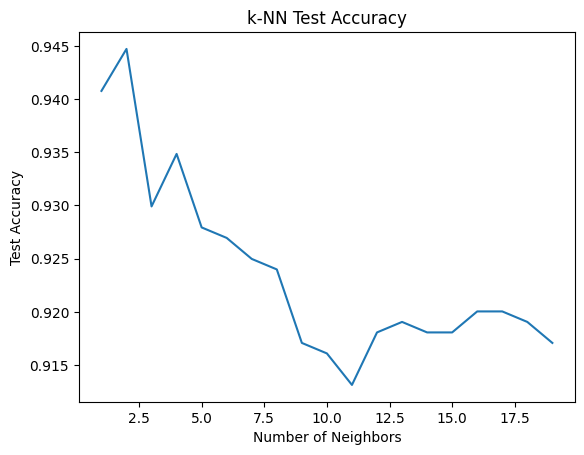

2 0.9447186574531096


In [51]:
# Let's move to kNN. Let's determine which k value is the best.
# kNN should not be affected by the distribution of the data
k_range = range(1, 20)
knns = []
for k in k_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=k), merged_df, name=f"kNN (k={k})"))
#display_evaluation(rfor_lossy, pcas[2], lda_lossy, bayes_onehot, *knns, show_plots=False)
display_evaluation(*knns, show_plots=False)

plt.plot(k_range, [_.acc for _ in knns])
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
kNN (k=1 onehot),92.89%,55.29%,58.02%,56.63%,76.97%
kNN (k=2 onehot),94.97%,96.88%,38.27%,54.87%,79.77%
kNN (k=3 onehot),94.18%,75.00%,40.74%,52.80%,78.49%
kNN (k=4 onehot),94.27%,92.59%,30.86%,46.30%,77.92%
kNN (k=5 onehot),94.08%,83.87%,32.10%,46.43%,78.55%
kNN (k=6 onehot),93.29%,80.95%,20.99%,33.33%,80.09%
kNN (k=7 onehot),93.29%,74.07%,24.69%,37.04%,79.98%
kNN (k=8 onehot),92.30%,63.64%,8.64%,15.22%,79.69%
kNN (k=9 onehot),92.10%,52.38%,13.58%,21.57%,78.73%
kNN (k=10 onehot),92.10%,53.33%,9.88%,16.67%,78.38%


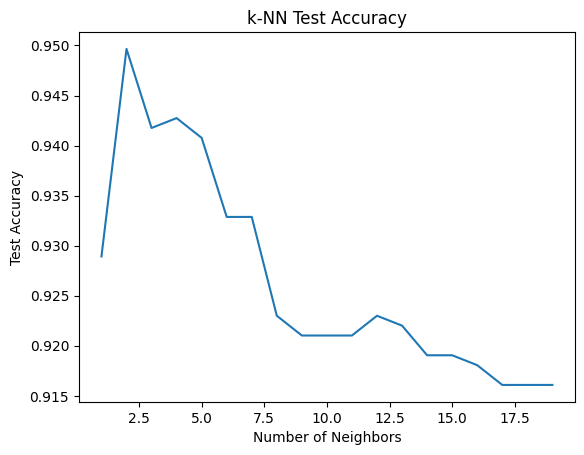

2 0.9496544916090819


In [52]:
# How does answer change for one-hot?
onehots = ['user_id', 'item_id', 'cat_id', 'seller_id', 'brand_id', 'merchant_id', 'action_type', 'age_range', 'day', 'month', 'day_of_year', 'day_of_week']
k_range = range(1, 20)
knns = []
for k in k_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=k), merged_df, onehot=onehots, name=f"kNN (k={k} onehot)"))
#display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, *knns, show_plots=False)
display_evaluation(*knns, show_plots=False)

plt.plot(k_range, [_.acc for _ in knns])
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
"kNN (k=2, p=1)",94.57%,79.55%,43.21%,56.00%,79.14%
"kNN (k=2, p=2)",94.47%,76.60%,44.44%,56.25%,80.15%
"kNN (k=2, p=3)",94.57%,78.26%,44.44%,56.69%,80.86%
"kNN (k=2, p=4)",94.67%,81.40%,43.21%,56.45%,81.68%
"kNN (k=2, p=5)",94.57%,79.55%,43.21%,56.00%,81.58%
"kNN (k=2, p=9999)",93.68%,100.00%,20.99%,34.69%,67.28%


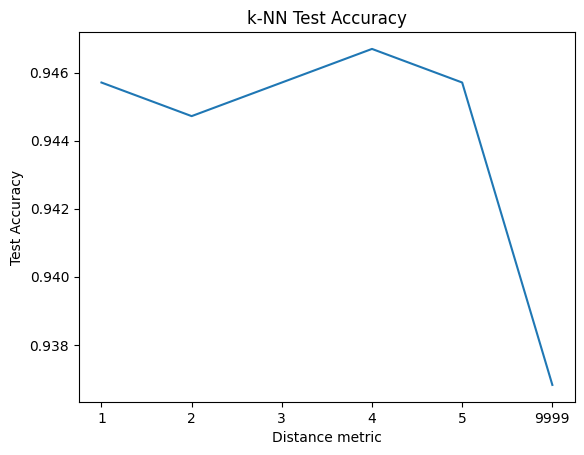

4 0.9466929911154985


In [53]:
knns = []
p_range = [1, 2, 3, 4, 5, 9999] # 9999 represents Linf

for p in p_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=2, p=p), merged_df, name=f"kNN (k=2, p={p})"))
#display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, *knns, show_plots=False)
display_evaluation(*knns, show_plots=False)
plt.plot([1, 2, 3, 4, 5, 6], [_.acc for _ in knns])
plt.xticks([1, 2, 3, 4, 5, 6], p_range)
plt.xlabel('Distance metric')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(p_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

In [66]:
# Let's see about Parzen windows

pred_func = lambda model, X_test: np.argmax(np.exp(model.score(X_test)), axis=1)
proba_func = lambda model, X_test: np.exp(model.score_samples(X_test))

windows = [0.1, 0.3, 0.5, 0.7, 0.9]
parzens = []
# How do we evaluate Parzen Windows?

# for window in windows:
#     parzens.append(evaluate(KernelDensity(bandwidth=window), merged_df, name=f"Parzen ({window})", pred_func=pred_func, proba_func=proba_func))
# display_evaluation(*parzens, show_plots=False)

# plt.plot(windows, [_.acc for _ in parzens])
# plt.xlabel('Window Size')
# plt.ylabel('Test Accuracy')
# plt.title('Parzen Windows Test Accuracy')
# plt.show()
# print(windows[np.argmax([_.acc for _ in parzens])], np.max([_.acc for _ in parzens]))

In [ ]:
# The fun stuff! Generic optimization through neural networks!


# Model Evaluation
Let's do this once we're happy with all our models